In [1]:
import pandas as pd
import numpy as np
import regex as re

In [2]:
dataset = pd.read_csv('data/data_clean_removed.csv')
dataset.drop(["Unnamed: 0"],inplace= True,axis = 1)

In [3]:
dataset = dataset.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [4]:
dataset.head(5)

,Price,Space,Rooms,Market,Year,elevator,Parkingplace,balkon,taras,ogrdek,district,street,level,max_level
0,4000000.0,560.00,4,wtórny,2015,1,1,1,1,1,Wawer,Patriotów,3,3
1,4000000.0,560.00,4,wtórny,2015,1,1,1,1,1,Wawer,Patriotów,3,3
2,21350100.0,487.75,10,wtórny,2021,1,1,0,0,0,Śródmieście,Elektryczna,6,6
3,19900000.0,487.00,6,wtórny,2001,1,1,0,0,0,Mokotów,Cybulskiego,5,5
4,795900.0,445.00,2,pierwotny,2022,1,1,0,0,0,Praga-Południe,Gocław,4,8


In [5]:
dataset_dummies = pd.get_dummies(dataset,columns=['Market','street','district'])

## Finding most suitable model

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.linear_model import BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression
from xgboost.sklearn import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [7]:
algorithms = [['gradient_boost_reg',GradientBoostingRegressor()],['ElasticNet',ElasticNet()],['SGDREG',SGDRegressor()],["SVR",SVR()],["BsyRidge",BayesianRidge()],["KerRidge",KernelRidge()],["LR",LinearRegression()],
                ["XGBReg",XGBRegressor()],["CatBoostReg",CatBoostRegressor()]]

In [8]:
score = []
name_list = [] 

def train_predict_save_metrics(algorithms_list,dataset):
    x = dataset.iloc[:,1:]
    y =  dataset.iloc[:,-1]
    kfold = KFold(n_splits=10,shuffle=True, random_state=42)
    for name, alg in algorithms_list:
        cv_results = cross_val_score(alg, x, y, cv=kfold, scoring='neg_root_mean_squared_error')
        score.append(cv_results)
        name_list.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)

In [9]:
train_predict_save_metrics(algorithms,dataset_dummies)

gradient_boost_reg: -0.005659 (0.012677)


C:\Users\Krzysztof\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


ElasticNet: -0.004275 (0.012263)
SGDREG: -1099463710120596.750000 (718347252758982.625000)
SVR: -0.094072 (0.017669)
BsyRidge: -0.006371 (0.013127)
KerRidge: -0.005830 (0.012441)
LR: -0.006374 (0.013130)
XGBReg: -0.008208 (0.016416)
Learning rate set to 0.053345
0:	learn: 0.0135044	total: 136ms	remaining: 2m 16s
1:	learn: 0.0133243	total: 145ms	remaining: 1m 12s
2:	learn: 0.0131465	total: 154ms	remaining: 51.1s
3:	learn: 0.0129711	total: 162ms	remaining: 40.4s
4:	learn: 0.0127980	total: 171ms	remaining: 34s
5:	learn: 0.0126273	total: 180ms	remaining: 29.8s
6:	learn: 0.0124588	total: 189ms	remaining: 26.8s
7:	learn: 0.0122926	total: 197ms	remaining: 24.5s
8:	learn: 0.0121286	total: 206ms	remaining: 22.7s
9:	learn: 0.0119668	total: 214ms	remaining: 21.2s
10:	learn: 0.0118072	total: 223ms	remaining: 20s
11:	learn: 0.0116497	total: 231ms	remaining: 19s
12:	learn: 0.0114943	total: 240ms	remaining: 18.2s
13:	learn: 0.0113723	total: 248ms	remaining: 17.5s
14:	learn: 0.0112207	total: 257ms	rem

C:\Users\Krzysztof\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
1 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Krzysztof\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Krzysztof\AppData\Roaming\Python\Python39\site-packages\catboost\core.py", line 5590, in fit
    return self._fit(X, y, cat_features, None, None, None, sample_weight, None, None, None, None, baseline,
  File "C:\Users\Krzysztof\AppData\Roaming\Python\

In [10]:
import matplotlib.pyplot as plt
plt.style.use('Solarize_Light2')

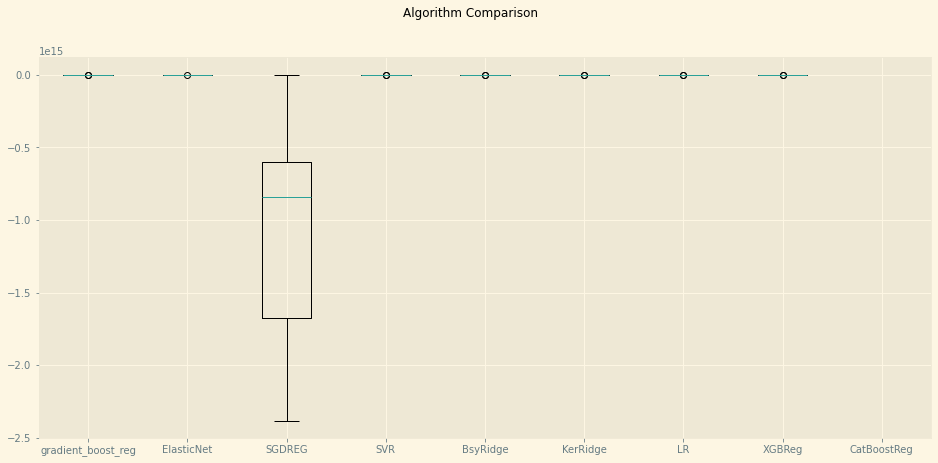

In [11]:
fig = plt.figure(figsize = [16,7])
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(score)
ax.set_xticklabels(name_list)
plt.show()

In [12]:
dict = {}
for x,y in zip(name_list,score):
    dict[x] = y.mean()

In [13]:
dict_sorted = {k: v for k, v in sorted(dict.items(), key=lambda item: item[1])}

In [14]:
dict_sorted

{'SGDREG': -1099463710120596.8,
 'SVR': -0.09407228309910645,
 'XGBReg': -0.00820817333527657,
 'LR': -0.006373948143736448,
 'BsyRidge': -0.00637076810676587,
 'KerRidge': -0.005830291097905729,
 'gradient_boost_reg': -0.005658647134498622,
 'ElasticNet': -0.004275141875846852,
 'CatBoostReg': nan}

In [15]:
dict_sorted.pop('SGDREG')
dict_sorted.pop('CatBoostReg')
dict_sorted.pop('SVR')

-0.09407228309910645

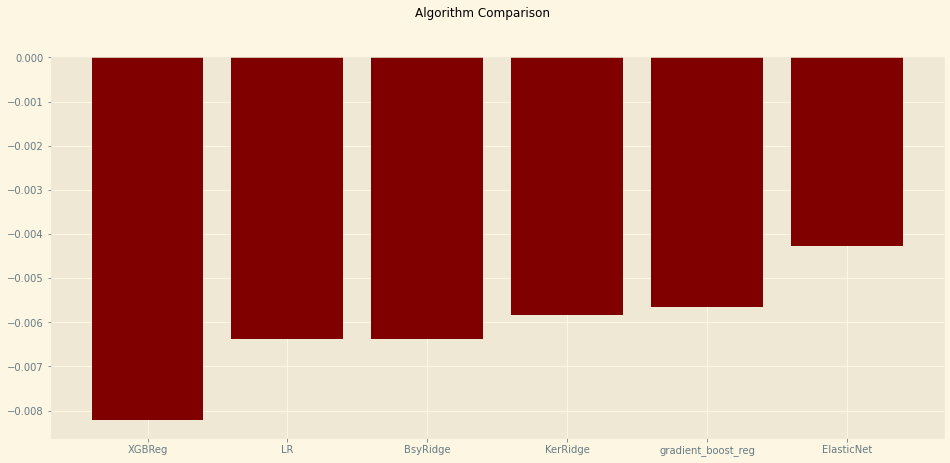

In [16]:
fig = plt.figure(figsize = [16,7])
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.bar(range(len(dict_sorted)),list(dict_sorted.values()),tick_label = list(dict_sorted.keys()),color ='maroon')
plt.show()

## Tuning model 

In [17]:
from sklearn.linear_model import ElasticNetCV

In [31]:
models = [
    ['ElasticNet',ElasticNetCV(),{
    'alphas': np.arange(0.1, 2, 0.5),
    'l1_ratio': np.arange(0.1,1,0.3),
    }],
    ['gradient_boost_reg',GradientBoostingRegressor(),{
    'learning_rate': np.arange(0.05, 1, 0.05),
    'max_depth': np.arange(3,10,1),
    'n_estimators': np.arange(50,250,50)
    }],
    ["KerRidge",KernelRidge(),{'alpha': np.arange(0.1,2,0.5)}]
    ]

In [28]:
X_train, X_test, y_train, y_test = train_test_split(dataset_dummies.drop('Price',axis=1),dataset_dummies['Price'] , test_size=0.2, random_state=1234)
ElasticNet , ElasticNet_model, ElasticNet_dic = models[0]

In [29]:
rand_auc = RandomizedSearchCV(estimator=ElasticNet_model, param_distributions=ElasticNet_dic, n_iter=5, scoring='neg_root_mean_squared_error', cv=5, verbose=True)
rand_auc.fit(X_train, y_train)
rand_auc.best_score_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


ValueError: 
All the 25 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Krzysztof\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Krzysztof\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py", line 1687, in fit
    alphas = np.tile(np.sort(alphas)[::-1], (n_l1_ratio, 1))
  File "<__array_function__ internals>", line 5, in sort
  File "c:\Users\Krzysztof\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py", line 998, in sort
    a.sort(axis=axis, kind=kind, order=order)
numpy.AxisError: axis -1 is out of bounds for array of dimension 0


In [32]:
gradient_boost_reg , gradient_boost_reg_model, gradient_boost_reg_dic = models[1]
rand_auc = RandomizedSearchCV(estimator=gradient_boost_reg_model, param_distributions=gradient_boost_reg_dic, n_iter=5, scoring='neg_root_mean_squared_error', cv=5, verbose=True)
rand_auc.fit(X_train, y_train)
rand_auc.best_score_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


-439137.42423422716

In [33]:
KerRidge_reg , KerRidge_model, KerRidge_dic = models[2]
rand_auc = RandomizedSearchCV(estimator=KerRidge_model, param_distributions=KerRidge_dic, n_iter=5, scoring='neg_root_mean_squared_error', cv=5, verbose=True)
rand_auc.fit(X_train, y_train)
rand_auc.best_score_

C:\Users\Krzysztof\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 4 candidates, totalling 20 fits


-445633.64375644317

## Auto Sklearn


### TO DO
-   mean bar plot
- feature importance
- hyperparametr optimiznation
